<a href="https://colab.research.google.com/github/adin786/mot-data/blob/main/mot_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GOV.uk MOT data analysis
I have an interest in the automotive industry, and came across an official UK government dataset of mot test records.  I will perform an exploratory analysis, on data I haven't seen before to see if I can make any meaningful statistical conclusions about probability of a vehicle passing the test first time.

# Imports

In [29]:
import pandas as pd
import numpy as np
import os
# For sqlite database
import sqlite3
from sqlite3 import Error

import matplotlib.pyplot as plt
import seaborn as sns

# Load in data

In [2]:
df = pd.read_csv(os.path.join('drive','MyDrive','Data','mot-glasgow.csv'))

In [3]:
df.test_result_code.unique()

array(['P', 'F', 'PRS', 'ABR', 'ABA', 'ABRVE'], dtype=object)

In [4]:
df.head()

,Unnamed: 0,test_id,vehicle_id,test_date,test_class_id,test_type,test_result_code,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
0,0,89719943,343699759,2019-04-01,4,NT,P,43500,G,PEUGEOT,BOXER,WHITE,DI,2198,2014-03-20
1,1,273750413,753234121,2019-04-01,4,NT,P,29730,G,BMW,X1,BLACK,DI,1995,2016-03-18
2,2,839477323,1499010618,2019-04-01,4,NT,F,143129,G,VOLKSWAGEN,CADDY,WHITE,DI,1968,2006-09-26
3,3,1614166795,537938057,2019-04-01,4,RT,P,27114,G,AUDI,A5,WHITE,DI,1968,2015-09-02
4,4,707053023,191299390,2019-04-01,4,NT,F,197200,G,BMW,3 SERIES,BLACK,DI,1995,2006-06-19


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631635 entries, 0 to 631634
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Unnamed: 0         631635 non-null  int64 
 1   test_id            631635 non-null  int64 
 2   vehicle_id         631635 non-null  int64 
 3   test_date          631635 non-null  object
 4   test_class_id      631635 non-null  int64 
 5   test_type          631635 non-null  object
 6   test_result_code   631635 non-null  object
 7   test_mileage       631635 non-null  int64 
 8   postcode_area      631635 non-null  object
 9   make               631635 non-null  object
 10  model              631635 non-null  object
 11  colour             631635 non-null  object
 12  fuel_type          631635 non-null  object
 13  cylinder_capacity  631635 non-null  int64 
 14  first_use_date     631635 non-null  object
dtypes: int64(6), object(9)
memory usage: 72.3+ MB


In [6]:
df.columns

Index(['Unnamed: 0', 'test_id', 'vehicle_id', 'test_date', 'test_class_id',
       'test_type', 'test_result_code', 'test_mileage', 'postcode_area',
       'make', 'model', 'colour', 'fuel_type', 'cylinder_capacity',
       'first_use_date'],
      dtype='object')

# Data cleaning part 1

In [7]:
# Change to categorical datatypes
df['make'] = df['make'].astype('category')
df['model'] = df['model'].astype('category')
df['colour'] = df['colour'].astype('category')
df['fuel_type'] = df['fuel_type'].astype('category')
df['test_type'] = df['test_type'].astype('category')
df['test_result_code'] = df['test_result_code'].astype('category')
df['test_class_id'] = df['test_class_id'].astype('category')
 
df['test_date'] = pd.to_datetime(df['test_date'],format='%Y-%m-%d %H:%M:%S')
df['first_use_date'] = pd.to_datetime(df['first_use_date'],format='%Y-%m-%d %H:%M:%S')

In [8]:
# Drop redundant features
df = df.drop('postcode_area',axis=1)
df = df.drop('Unnamed: 0', axis=1)

In [9]:
# Drop duplicates based on vehicle_id
# df = df.drop_duplicates(subset='vehicle_id',keep='first')

# Probably don't want to delete every repeated vehicle ID entry, since the dataset includes several years of data.  Safer to just drop rows with anything except P or F results
# df.drop(df)
df = df.drop(df[df['test_result_code'].isin(['PRS', 'ABR', 'ABA', 'ABRVE'])].index)
df.test_result_code.unique()


['P', 'F']
Categories (2, object): ['P', 'F']

**Note to self:** 

I think there may be value in building a table of vehicle ids, and for each vehicle aggregate certain parameters such as:
- Existing features like vehicle age, mileage
- Did it "pass first time" it's most recent test?
- Did it "pass first time" it's 2nd most recent test?
- Did it "pass first time" it's 3rd most recent test? (surely there must be an increasing probability of test pass for cars with a history of passing first time?)

In [10]:
# Add vehicle_age calculated feature, units are years
df['vehicle_age'] = (df['test_date'] - df['first_use_date']).dt.days / 365

# Added pass_first feature which is true/false if the result was a P or not.
df['pass_first'] = False
df.loc[df['test_result_code'] == 'P','pass_first'] = True
df['pass_first'].value_counts()

True     466698
False    137192
Name: pass_first, dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603890 entries, 0 to 631634
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   test_id            603890 non-null  int64         
 1   vehicle_id         603890 non-null  int64         
 2   test_date          603890 non-null  datetime64[ns]
 3   test_class_id      603890 non-null  category      
 4   test_type          603890 non-null  category      
 5   test_result_code   603890 non-null  category      
 6   test_mileage       603890 non-null  int64         
 7   make               603890 non-null  category      
 8   model              603890 non-null  category      
 9   colour             603890 non-null  category      
 10  fuel_type          603890 non-null  category      
 11  cylinder_capacity  603890 non-null  int64         
 12  first_use_date     603890 non-null  datetime64[ns]
 13  vehicle_age        603890 non-null  float64 

**Summary of data cleaning**
- Dropped postcode as all rows are from glasgow.
- Dropped "unnamed" column (I think this just came from not removing the df index during an earlier df.to_csv() call in the data gathering stage).
- Changed to categorical data types for efficiency.
- Changed dates to datetime type.
- Added vehicle age as it seems more relevant than simple date values.
 - *May want to check for any vehicles under 3 years old* since MOT test shouldn't be required.
- 

# Exploration

In [12]:
temp = df.pass_first.value_counts()
 
print(f'Percentage of entries with pass first time: {temp[True] / temp.sum() *100:.1f}%\n')
print('Count of pass_first')
print(temp)

Percentage of entries with pass first time: 77.3%

Count of pass_first
True     466698
False    137192
Name: pass_first, dtype: int64


In [13]:
# Print list of top 10 vehicle brands in terms of the number of passes first
# Will need to divide by the number of entries per brand, to make this not just 
# be a list of the most tested.
df.groupby('make')['pass_first'].sum().sort_values(ascending=False).head(10)

make
VAUXHALL         60436
FORD             57488
VOLKSWAGEN       40752
RENAULT          26034
AUDI             24922
BMW              22447
PEUGEOT          22166
NISSAN           21953
TOYOTA           18442
MERCEDES-BENZ    18001
Name: pass_first, dtype: int64

In [14]:
# List top 5 vehicle brands according to number of entries
top5makes = df.groupby('make').make.count().sort_values(ascending=False).head(5)
top5makes_list = list(top5makes.index)
print(top5makes)

make
VAUXHALL      81029
FORD          75440
VOLKSWAGEN    52652
RENAULT       36289
AUDI          29743
Name: make, dtype: int64


### **Observations on vehicle_age**
Highlights:
- Vehicle age is cyclic and peaks around the annual "birthday" of each vehicle, people are getting the MOT test pretty consistently close to their annual deadline
- 7.6% of vehicle ages in this dataset were 

In [53]:
# Question, are there any tests completed on cars under 3 years old?  Shouldn't be many
condition = df.vehicle_age < 3
temp = df[condition]['test_id'].count() / df['test_id'].count()
print(f'Percentage of tests on vehicles with age less than 3years...\t\t{temp*100:.1f}%')

# A little surprising, I think vehicles can be tested around 1 month before the due date.  
# How many of these were tested in the last month before 3 years old?
condition = (df.vehicle_age < (3)) & (df.vehicle_age > (3-30/365))
temp = df[condition]['test_id'].count() / df['test_id'].count()
print(f'Percentage of tests on vehicles with age between 2yrs 11mo to 3yrs...\t{temp*100:.1f}%')

# Let's count how many were less than 2yrs 11mo
condition = (df.vehicle_age > 3) & (df.vehicle_age < (3+30/365))
temp = df[condition]['test_id'].count() / df['test_id'].count()
print(f'Percentage of tests on vehicles with age over 3yrs...\t\t{temp*100:.1f}%')

Percentage of tests on vehicles with age less than 3years...		10.2%
Percentage of tests on vehicles with age between 2yrs 11mo to 3yrs...	7.6%
Percentage of tests on vehicles with age over 3yrs...		1.8%


Percentage of tests on vehicles with age between 2yrs 11mo to 3yrs: 2.5%


In [42]:
binned_ages = pd.cut(df.vehicle_age, np.array([1,2]))
binned_ages

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
631629    NaN
631630    NaN
631631    NaN
631633    NaN
631634    NaN
Name: vehicle_age, Length: 603890, dtype: category
Categories (1, interval[int64]): [(1, 2]]

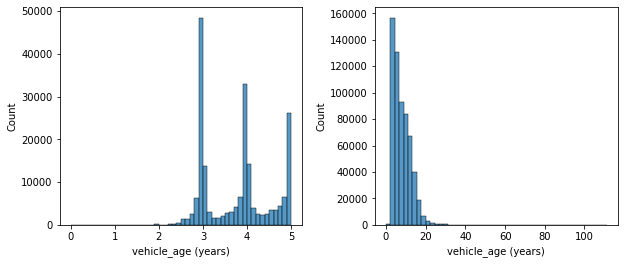

In [18]:
# Plot histogram of vehicle_age at time of MOT test
fig, axs = plt.subplots(1,2)
fig.set_figwidth(10,15)
fig.subplots_adjust(wspace=.3)
sns.histplot(ax=axs[0],data=df,x=df.vehicle_age,bins=50,binrange=(0,5));
sns.histplot(ax=axs[1],data=df,x=df.vehicle_age,bins=50,);
axs[0].set(xlabel='vehicle_age (years)');
axs[1].set(xlabel='vehicle_age (years)');

- Above left hand plot: shows we have a cyclic behaviour where every year, there is apeak of vehicles getting tested just before they turn another year old.
 - This only appears to be from around 3 years old, makes sense since the rules are that an MOT test is only required when the vehicle hits 3 years old.  So everyone must rush to get their car tested close to the deadline!
- Right hand plot: Doesn't make a lot of sense for there to be many cars going around at 100 years old! Let's investigate

In [18]:
# Looks like 2nd plot extends all the way to 100 years, maybe we have some 
# outliers.  List the oldest few vehicles
df.sort_values(by='vehicle_age', ascending=False).head(10)

,test_id,vehicle_id,test_date,test_class_id,test_type,test_result_code,test_mileage,make,model,colour,fuel_type,cylinder_capacity,first_use_date,vehicle_age,pass_first
475861,22381159,1252955741,2019-07-03,4,NT,F,60838,VAUXHALL,CORSA,BLUE,PE,1200,1908-06-17,111.117808,False
115382,244857551,503545350,2019-06-01,4,NT,P,7062,FORD,MODEL T,GREEN,PE,2900,1910-01-01,109.487671,True
76581,569773399,1493116861,2019-05-11,4,NT,P,87805,CHRYSLER,UNCLASSIFIED,CREAM,PE,3600,1925-12-31,93.421918,True
50845,1028019775,1092759106,2019-04-27,4,NT,P,31004,HUMBER,15/40TOURER,RED,PE,2107,1926-02-09,93.273973,True
89748,1913386137,8382296,2019-05-18,4,NT,P,77319,ROLLS ROYCE,SALOON,BLUE,PE,3104,1928-07-31,90.857534,True
557420,1047285881,117847767,2019-08-24,4,NT,P,42558,BUICK,UNCLASSIFIED,RED,PE,6000,1929-12-31,89.706849,True
559784,330764867,789709581,2019-08-26,4,NT,P,1,AUSTIN,UNCLASSIFIED,BLUE,PE,858,1933-09-26,85.972603,True
127998,980947277,698996478,2019-06-08,4,NT,P,79149,MG,SA,BLUE,PE,1998,1938-12-14,80.536986,True
59501,1298336911,566047820,2019-05-01,4,NT,F,76253,WOLSLEY,WOLSLEY,BLUE,PE,-1,1938-12-31,80.386301,False
499496,1040451729,1155617846,2019-07-18,4,NT,P,16313,FORD,CONVERTIBLE,BLUE,PE,5000,1946-01-01,73.591781,True


- There's no chance there is a Vauxhall corsa at 100 years old!

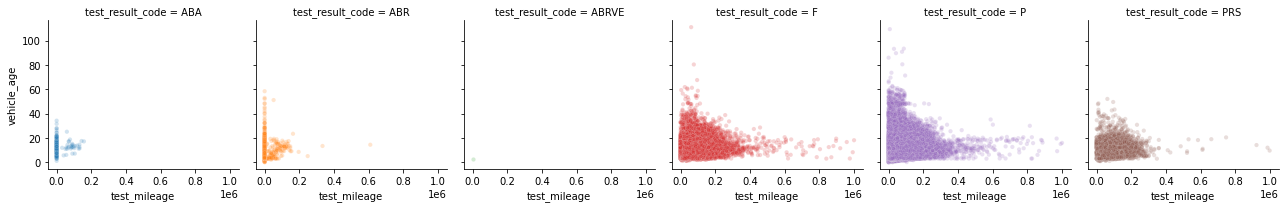

In [19]:
# Try a facet grid to plot different categories
g = sns.FacetGrid(df, col='test_result_code', hue='test_result_code')
g.map(sns.scatterplot, 'test_mileage', 'vehicle_age', alpha=0.2, size=1);


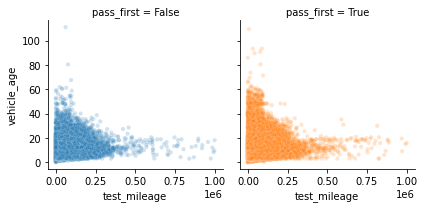

In [ ]:
# Makes more sense to plot by pass_first, since  this is True only if 
# test_result_code = P
g = sns.FacetGrid(df, col='pass_first', hue='pass_first')
g.map(sns.scatterplot, 'test_mileage', 'vehicle_age', alpha=0.2, size=1);

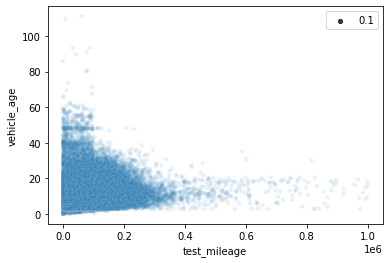

In [ ]:
sns.scatterplot(data=df, x='test_mileage', y='vehicle_age', alpha=0.1, size=0.1);

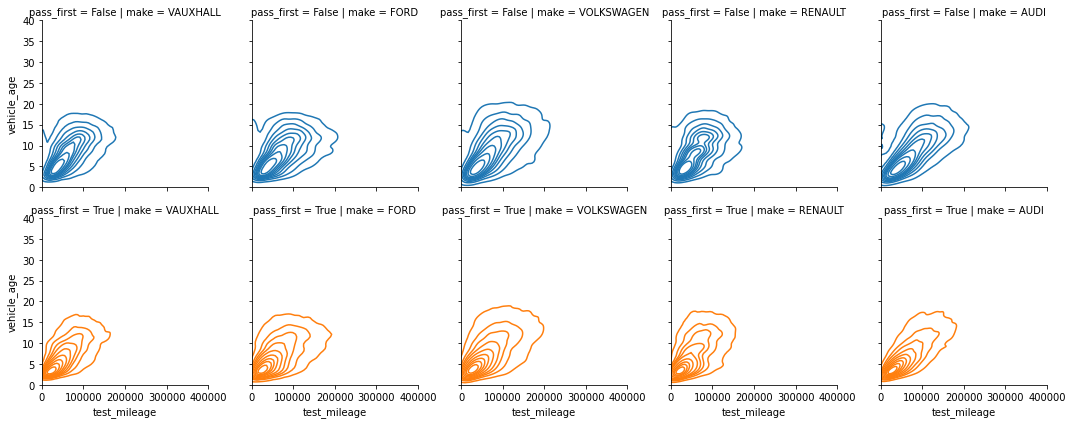

In [ ]:
# Try a facet plot but across the top 5 vehicle makes
df_m = df[df.make.isin(top5makes_list)]
df_m.make.cat.remove_unused_categories(inplace=True)
# print(df_m.make.value_counts())

g = sns.FacetGrid(df_m, hue='pass_first', col='make', col_order=top5makes_list, row='pass_first', ylim=(0,40), xlim=(0,400000))
# g.map(sns.scatterplot, 'test_mileage', 'vehicle_age', alpha=0.1, size=1);
g.map(sns.kdeplot, 'test_mileage', 'vehicle_age');

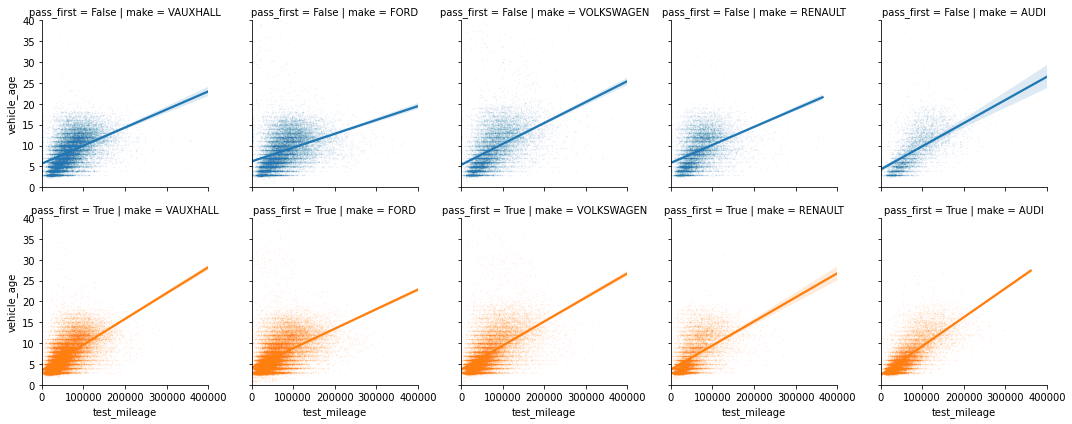

In [ ]:
# Try a facet plot but across the top 5 vehicle makes
df_m = df[df.make.isin(top5makes_list)]
df_m.make.cat.remove_unused_categories(inplace=True)
# print(df_m.make.value_counts())

g = sns.FacetGrid(df_m, hue='pass_first', col='make', col_order=top5makes_list, row='pass_first', ylim=(0,40), xlim=(0,400000))
# g.map(sns.scatterplot, 'test_mileage', 'vehicle_age', alpha=0.1, size=1);
g.map(sns.regplot, 'test_mileage', 'vehicle_age', scatter_kws=dict(alpha=0.1, s=0.1));

In [ ]:
df_m.make.head(5)

2     VOLKSWAGEN
3           AUDI
6       VAUXHALL
7           FORD
10          FORD
Name: make, dtype: category
Categories (5, object): ['AUDI', 'FORD', 'RENAULT', 'VAUXHALL', 'VOLKSWAGEN']

In [ ]:
#sns.pairplot(df_s[['vehicle_age','test_mileage','cylinder_capacity','test_result_code']], 
   #          hue='test_result_code',
      #       diag_kind='kde', plot_kws=dict(alpha=0.3));

In [ ]:
ax = sns.boxplot(data=df_s, x='test_result_code', 
y='vehicle_age', fliersize=1)
 
ax.set_ylim(0,15000)

In [ ]:
ax = sns.violinplot(data=df_s, x='test_result_code', 
y='vehicle_age')
 
ax.set_ylim(0,15000)

In [ ]:
sns.jointplot(data=df_s, hue='test_result_code', 
x='test_mileage', y='vehicle_age')

- Drop duplicates from df
- Validate that pass_first column is making sense.
- 